## **Stock Price Forecasting with LSTMs**
#### In this tutorial we show how a simple LSTM can predict stock prices in the short term.

#### A Long-Short Term Memory (LSTM) is a type of Recurrent Neural Network that is specially suited for time-series prediction problems. It is internally composed by two kind of units, hidden units, which as in CNNs contain a hidden representation of the inputs, and gated units, which control the amount of information that flows from the inputs, to the hidden units and to the outputs.

#### The gated structure of LSTMs, make them very efficient when working with large time series. They are able to understand long-term dependencies in temporal data, controlling which information should be "remembered" and which "forgotted".

#### In the present tutorial we use Keras with Tensorflow back-end to predict the stock prices of Microsoft from 2012 to 2017. We experiment with an LSTM and two variants of the same family: Bi-directional LSTM and GRU.


In [2]:
pip install keras tensorflow


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 5.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 1.8/376.0 MB 9.1 MB/s eta 0:00:41
   ---------------------------------------- 3.7/376.0 MB 9.1 MB/s eta 0:00:41
    --------------------------------------- 6.0/376.0 MB 10.0 MB/s eta 0:00:38
    --------------------------------------- 8.7/376.0 MB 10.5 MB/s eta 0:00:35
   - -------------------------------------- 10.0/376.0 MB 9.7 MB/s eta 0:00:38
   - -------------------------------------- 12.3/376.0 MB 10.0 MB/s eta 0:00:37
   - -------------------------------------- 14.9/376.0 MB 10.3 MB/s eta 0:00:35
   - -------------------------------------- 16.5/376.0 MB 10.1 MB/s eta 0:00:36
   - -------------------------------------- 18.6/376.0 MB 10.0 MB/s eta 0:00:36
  

In [ ]:
import os
import sys
import pandas as pd
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Bidirectional, LSTM, GRU
import tensorflow as tf
from bokeh.io import output_notebook
from utils import (get_number_processors, plot_series, to_1dimension, plot_series_prediction)

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tf.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())

%load_ext autoreload
%autoreload 2

output_notebook()

In [3]:
import keras
print(keras.__version__)

import tensorflow as tf
print(tf.__version__)


3.10.0
2.19.0


In [ ]:
conda activate base


In [5]:
import os
import sys
import pandas as pd
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Bidirectional, LSTM, GRU
import tensorflow as tf
from bokeh.io import output_notebook
from utils import (get_number_processors, plot_series, to_1dimension, plot_series_prediction)

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tf.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())

%load_ext autoreload
%autoreload 2

output_notebook()

OS:  win32
Python:  3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
Keras:  3.10.0
Tensorflow:  2.19.0
Numpy:  1.26.4
Number of CPU processors:  16


Loading BokehJS ...


## Data
## The data we are going to use is Microsoft stock prices from 2012 to 2017. The data can be accessed directly in Yahoo finance.

## The parameter TIME_AHEAD sets the number of days that you want to predict in advance. The more in the future you want to predict, the less accurate the prediction will be.

In [13]:
DATA = os.path.join('data', 'MSFT_2012_2017.csv')
EPOCHS = 5
TEST_SIZE = 0.3
TIME_AHEAD = 1 #prediction step
BATCH_SIZE = 1
UNITS = 25

In [14]:
df = pd.read_csv("MSFT_2012_2017.csv")
df = df.drop(['Adj Close', 'Volume'], axis=1)
print(df.shape)
df.head()

(1509, 5)


,Date,Open,High,Low,Close
0,2012-01-03,26.549999,26.959999,26.389999,26.770000
1,2012-01-04,26.820000,27.469999,26.780001,27.400000
2,2012-01-05,27.379999,27.730000,27.290001,27.680000
3,2012-01-06,27.530001,28.190001,27.530001,28.110001
4,2012-01-09,28.049999,28.100000,27.719999,27.740000


##### To simplify the problem, we are going to take as input the average of the Open, High, Low and Close values.

In [16]:
print(df.dtypes)


Date      object
Open     float64
High     float64
Low      float64
Close    float64
dtype: object


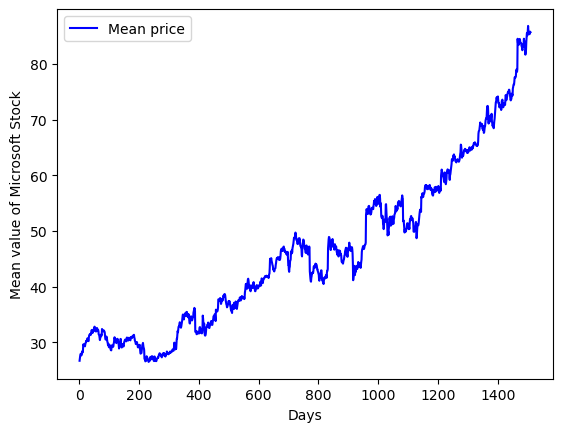

In [19]:
numeric_df = df.select_dtypes(include=[np.number])
mean_price = numeric_df.mean(axis=1)
plot_series(mean_price, xlabel='Days', ylabel='Mean value of Microsoft Stock', color='b', legend='Mean price')


#### The next step is to scale the dataset, this generally helps the prediction to be more accourate

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1)) #other typical scale values are -1,1
mean_price = scaler.fit_transform(np.reshape(mean_price.values, (len(mean_price),1)))

#### Once, the data has been scaled, we can create the train and test sets.

In [21]:

train, test = train_test_split(mean_price, test_size=TEST_SIZE, shuffle=False)
print(train.shape)
print(test.shape)

(1056, 1)
(453, 1)


In [22]:

X_train, y_train = to_1dimension(train, TIME_AHEAD)
X_test, y_test = to_1dimension(test, TIME_AHEAD)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1054, 1, 1) (1054,)
(451, 1, 1) (451,)



## **LSTM**

### Now we are going to test different RNN structures.



In [23]:

def create_symbol(model_name='LSTM', units=10, activation='linear', time_ahead=1):
    model = Sequential()
    if model_name == 'LSTM':
        model.add(LSTM(units, input_shape=(1, time_ahead)))
    elif model_name == 'BiLSTM':
        model.add(Bidirectional(LSTM(units), input_shape=(1, time_ahead)))
    elif model_name == 'GRU':
        model.add(GRU(units, input_shape=(1, time_ahead)))
    else:
        raise ValueError("Wrong model name")
    model.add(Dense(1))
    model.add(Activation('linear'))
    return model

#### Let's train the model. For optimization, we use ADAM algorithm. In time series, adaptative optimization methods tend to get better results than traditional stochastic gradient descent methods. You can play with the different optimizers available in Keras.

In [24]:

model = create_symbol(model_name='LSTM', units=UNITS, time_ahead=TIME_AHEAD)
model.compile(optimizer='adam', loss='mean_squared_error') 

C:\Users\andyv\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/5
1054/1054 - 2s - 2ms/step - loss: 0.0067
Epoch 2/5
1054/1054 - 1s - 858us/step - loss: 9.3118e-05
Epoch 3/5
1054/1054 - 1s - 787us/step - loss: 9.4713e-05
Epoch 4/5
1054/1054 - 1s - 752us/step - loss: 9.8118e-05
Epoch 5/5
1054/1054 - 1s - 834us/step - loss: 9.2055e-05



### Once the model is trained, we can predict on the test set and obtain the RMSE value. The model prediction pred_test will have a shape of (num_rows, TIME_AHEAD), having the predicted values for the next TIME_AHEAD days.

In [26]:
y_test_inv = scaler.inverse_transform([y_test])
mean_price_inv = scaler.inverse_transform(mean_price)

In [27]:
pred_test = model.predict(X_test) #pred_test.shape = (num_rows, TIME_AHEAD)
pred_test = scaler.inverse_transform(pred_test)
score = math.sqrt(mean_squared_error(y_test_inv[0], pred_test[:,0]))
print('Test RMSE: %.2f' % (score))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test RMSE: 0.96


In [32]:
pred_train = model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(mean_price_inv, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       title='LSTM prediction', xlabel='Days', ylabel='Value of Microsoft Stock', 
                       legend=['True value','Training set','Test prediction'])

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


## BiLSTM


#### Now we can try with a Bi-directional LSTM (BiLSTM).



In [33]:

model = create_symbol(model_name='BiLSTM', units=UNITS, time_ahead=TIME_AHEAD)
model.compile(optimizer='adam', loss='mean_squared_error') 

C:\Users\andyv\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=1, verbose=2)


Epoch 1/5
1054/1054 - 2s - 2ms/step - loss: 0.0052
Epoch 2/5
1054/1054 - 1s - 1ms/step - loss: 9.1613e-05
Epoch 3/5
1054/1054 - 1s - 1ms/step - loss: 9.4491e-05
Epoch 4/5
1054/1054 - 1s - 1ms/step - loss: 9.3774e-05
Epoch 5/5
1054/1054 - 1s - 1ms/step - loss: 1.0361e-04


In [35]:
pred_test = model.predict(X_test)
pred_test = scaler.inverse_transform(pred_test)
score = math.sqrt(mean_squared_error(y_test_inv[0], pred_test[:,0]))
print('Test RMSE: %.2f' % (score))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test RMSE: 0.70


In [36]:
pred_train = model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(mean_price_inv, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       title='BiLSTM prediction', xlabel='Days', ylabel='Value of Microsoft Stock', 
                       legend=['True value','Training set','Test prediction'])

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## GRU

#### Finally, we are going to try with a Gated Recurrent Unit (GRU), which is a simplified version of LSTM.



In [38]:

model = create_symbol(model_name='BiLSTM', units=UNITS, time_ahead=TIME_AHEAD)
model.compile(optimizer='adam', loss='mean_squared_error') 

C:\Users\andyv\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=1, verbose=2)


Epoch 1/5
1054/1054 - 2s - 2ms/step - loss: 0.0049
Epoch 2/5
1054/1054 - 1s - 938us/step - loss: 9.2245e-05
Epoch 3/5
1054/1054 - 1s - 1ms/step - loss: 9.8768e-05
Epoch 4/5
1054/1054 - 1s - 1ms/step - loss: 1.0189e-04
Epoch 5/5
1054/1054 - 1s - 973us/step - loss: 9.9161e-05


In [40]:

pred_test = model.predict(X_test)
pred_test = scaler.inverse_transform(pred_test)
score = math.sqrt(mean_squared_error(y_test_inv[0], pred_test[:,0]))
print('Test RMSE: %.2f' % (score))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test RMSE: 0.83


In [41]:

pred_train = model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(mean_price_inv, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       title='GRU prediction', xlabel='Days', ylabel='Value of Microsoft Stock', 
                       legend=['True value','Training set','Test prediction'])

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



## Conclusion
#### In this tutorial we have seen how a LSTM (or other variants) can be used to predict the stock price given a temporal series of values.